In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from gbd_mapping import causes
from vivarium_inputs import get_measure

In [3]:
dfout = pd.read_hdf(r'../2019_12_16_15_24_27/output.hdf')

In [4]:
#print(dfout.head())
#print(dfout.shape)

In [6]:
#dfout.columns

In [4]:
dfout.reset_index(level='random_seed',inplace=True,drop=True)
#dfout.head()

In [5]:
dfout.reset_index(level='input_draw_number',inplace=True)
#dfout.head()

In [6]:
df_grpby_draws = dfout.groupby('input_draw_number',as_index=False).sum()
#print(df_grpby_draws.head())
print(df_grpby_draws.shape)

(100, 995)


In [89]:
deaths_sepsis = df_grpby_draws.filter(regex='input_draw_number|death_due_to_neonatal_sepsis')
deaths_sepsis.set_index('input_draw_number', inplace=True)
#deaths_sepsis.head()

In [90]:
person_time = df_grpby_draws.filter(regex='input_draw_number|person_time')
person_time.set_index('input_draw_number',inplace=True)
#person_time.head()

In [91]:
csmr_sepsis_columns = [i.replace('death_due_to','csmr') for i in deaths_sepsis.columns]
#csmr_sepsis_columns

In [92]:
person_time.columns = deaths_sepsis.columns
#person_time.head()

In [93]:
csmr_sepsis = deaths_sepsis.div(person_time)
csmr_sepsis.columns = csmr_sepsis_columns
csmr_sepsis = csmr_sepsis.fillna(0)

In [12]:
#csmr_measles.head()

In [94]:
csmr_mean = csmr_sepsis.mean()
csmr_mean= pd.DataFrame(csmr_mean, columns = ['csmr'])
csmr_mean.reset_index(inplace=True)
#csmr_mean

In [95]:
def extract_sex(x):
    sex = x.split('_')[8]
    return sex    

In [96]:
csmr_mean['sex'] = csmr_mean['index'].apply(extract_sex)


In [97]:
def extract_age(x):
    age = x.split('age_group_')
    age = ' '.join(age[1].split('_'))
    if age == 'early neonatal':
        age = '0 to 7 days'
    elif age == 'late neonatal':
        age = '7 to 28 days'
    elif age == 'post neonatal':
        age = '28 days to 1 year'
    #print(age)
    return age

In [98]:
csmr_mean['age_group'] = csmr_mean['index'].apply(extract_age)
age_groups = ['0 to 7 days','7 to 28 days','28 days to 1 year', '1 to 4', '5 to 9']
csmr_mean = csmr_mean[csmr_mean.age_group.isin(age_groups)]
#csmr_mean

In [99]:
csmr_sepsis_sim = csmr_mean.loc[:,'csmr':'age_group']
csmr_sepsis_sim['sex'] = csmr_sepsis_sim['sex'] + ' - Sim'
#csmr_sepsis_sim

In [100]:
plt.rcParams["figure.figsize"] = (5,5)

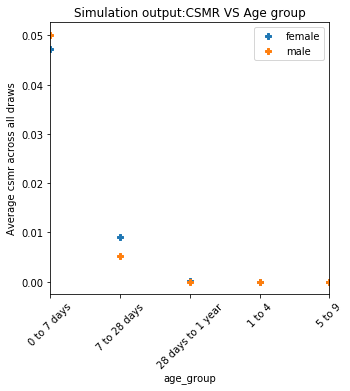

In [101]:
fig, ax = plt.subplots()
csmr_mean.groupby('sex').plot(x='age_group',y='csmr',marker = 'P',linestyle='',ax=ax)
plt.ylabel('Average csmr across all draws')
plt.title("Simulation output:CSMR VS Age group")
plt.xticks(range(5),csmr_mean['age_group'].unique(),rotation=45)
plt.legend([v[0] for v in csmr_mean.groupby('sex')['sex']])

In [36]:
csmr_sepsis_ind_act = get_measure(causes.neonatal_sepsis_and_other_neonatal_infections,'cause_specific_mortality_rate','India')

/share/code/kiranklc/miniconda/envs/vivarium/lib/python3.6/site-packages/vivarium_inputs/validation/raw.py:1405: UserWarning: Cause neonatal_sepsis_and_other_neonatal_infections deaths data may violate the following restrictions: yll age restriction .
  warnings.warn(f'{entity.kind.capitalize()} {entity.name} {measure} data may violate the '
/share/code/kiranklc/miniconda/envs/vivarium/lib/python3.6/site-packages/vivarium_inputs/validation/raw.py:1858: UserWarning: Data contains additional age groups beyond those specified by restriction range.
  warnings.warn('Data contains additional age groups beyond those specified by restriction range.')
/share/code/kiranklc/miniconda/envs/vivarium/lib/python3.6/site-packages/vivarium_inputs/validation/raw.py:1960: UserWarning: Data was only expected to contain values for age groups between ids 2 and 4 but also included values for age groups {5}.
  warnings.warn(f'Data was only expected to contain values for age groups between ids '


In [37]:
csmr_sepsis_ind_act.reset_index(inplace=True)
#csmr_sepsis_ind_act.head()

In [38]:
csmr_sepsis_2011_2015 = csmr_sepsis_ind_act.loc[csmr_sepsis_ind_act['year'].apply(lambda x: x.left in [2010,2011,2012,2013,2014,2015]),:]
#csmr_sepsis_2011_2015

In [39]:
csmr_sepsis_agg_years = csmr_sepsis_2011_2015.groupby(['sex','age'],as_index=False).mean()
#csmr_sepsis_agg_years

In [40]:
csmr_sepsis_agg_years['mean_draws'] = csmr_sepsis_agg_years.loc[:,'draw_0':'draw_999'].mean(axis=1)
#csmr_sepsis_agg_years[['sex','age','mean_draws']]

In [41]:
def convert_age_group(x):
    if x.right < 1:
        age_group = str(int(round(x.left*365)))+' to '+str(int(round((x.right)*365)))+' days'
    elif x.right == 1:
        age_group = str(int(round(x.left*365)))+' days to '+str(int(x.right))+' year'
    elif x.right == 125:
        age_group = str(int(round(x.left)))+ ' plus'
    else:
        age_group = str(int(x.left))+' to '+str(int(x.right-1))
    #print(age_group)
    return age_group

In [45]:
csmr_sepsis_agg_years['age_group'] = csmr_sepsis_agg_years['age'].apply(convert_age_group)
csmr_sepsis_agg_years = csmr_sepsis_agg_years[csmr_sepsis_agg_years.age_group.isin(age_groups)]
csmr_sepsis_gbd = csmr_sepsis_agg_years.loc[:,['sex','mean_draws','age_group']]
csmr_sepsis_gbd['sex'] = csmr_sepsis_gbd['sex'].str.lower()

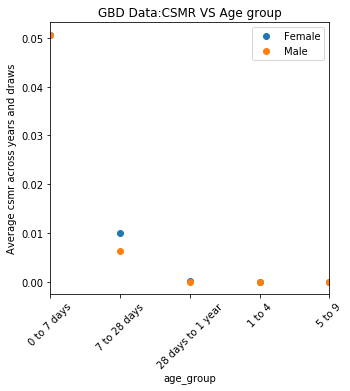

In [102]:
fig, ax = plt.subplots()
csmr_sepsis_agg_years.groupby('sex').plot(x='age_group',y='mean_draws',marker='o',linestyle='',ax=ax)
plt.ylabel('Average csmr across years and draws')
plt.title("GBD Data:CSMR VS Age group")
plt.xticks(range(5),csmr_sepsis_agg_years['age_group'].unique(), rotation=45)
plt.legend([v[0] for v in csmr_sepsis_agg_years.groupby('sex')['sex']])

In [105]:
csmr_sepsis_gbd.rename(columns = {'mean_draws':'csmr'},inplace=True)
#csmr_sepsis_gbd

In [106]:
csmr_sepsis_gbd['sex'] = csmr_sepsis_gbd['sex'] +' - GBD'
#csmr_sepsis_gbd

In [107]:
csmr_sepsis_ind = pd.concat([csmr_sepsis_gbd,csmr_sepsis_sim], sort=False)
#csmr_sepsis_ind

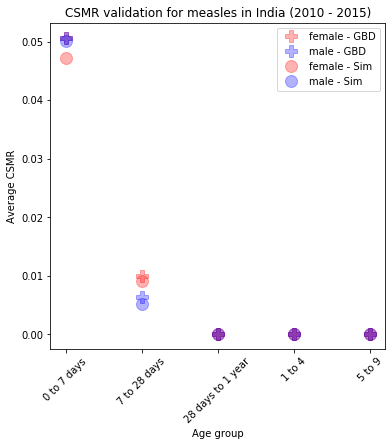

In [108]:
format_dict = {'female - GBD':"rP", 'male - GBD':"bP",'female - Sim':"ro",'male - Sim':"bo"}

fig, ax = plt.subplots()
for form in format_dict:
    df = csmr_sepsis_ind[csmr_sepsis_ind.sex == form]
    ax.plot(df.age_group,df.csmr, format_dict[form],linestyle='',ms=12,label=form, alpha=0.3)
ax.set_title('CSMR validation for measles in India (2010 - 2015)')    
ax.set_xlabel('Age group')
ax.set_ylabel('Average CSMR')
plt.xticks(rotation=45)
ax.legend()

In [109]:
def convert_age_num(x):
    age_group = x.split()
    if age_group[-1] == 'days':
        age = (int(age_group[0])+int(age_group[2]))/(2*365)
    elif age_group[-1] == 'year':
        age = (int(age_group[0])/365 + int(age_group[3]))/2
    elif age_group[-1] == 'plus':
        age = (int(age_group[0])+125)/2
    else:
        age = (int(age_group[0]) + int(age_group[2]))/2
    return round(age,2)

In [110]:
csmr_sepsis_gbd['mid_age'] = csmr_sepsis_gbd['age_group'].apply(convert_age_num)
csmr_sepsis_gbd['sex'] = csmr_sepsis_gbd['sex'].apply(lambda x: x.split('-')[0].rstrip())
#csmr_sepsis_gbd

In [111]:
csmr_sepsis_sim['mid_age'] = csmr_sepsis_sim['age_group'].apply(convert_age_num)
csmr_sepsis_sim['sex'] = csmr_sepsis_sim['sex'].apply(lambda x: x.split('-')[0].rstrip())
#csmr_sepsis_sim

In [112]:
csmr_sepsis_scatter = csmr_sepsis_gbd[['sex','csmr','mid_age']].merge(csmr_sepsis_sim[['sex','csmr','mid_age']], on = ['sex','mid_age'])
#csmr_sepsis_scatter

In [113]:
plt.rcParams["figure.figsize"] = (6,6)

In [114]:
import seaborn as sns

Text(0.5, 1.0, 'CSMR from simulation results vs CSMR from GBD data')

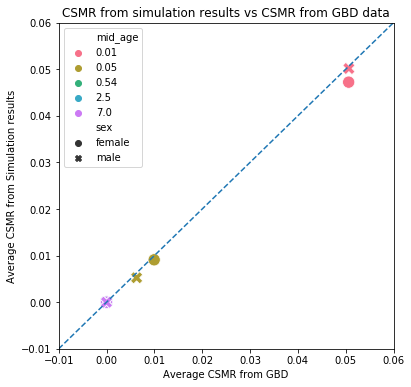

In [115]:
lims = [-0.01,0.06]
ax = sns.scatterplot(x="csmr_x", y="csmr_y", style="sex", hue="mid_age", s= 150, 
                     palette = sns.color_palette('husl',len(csmr_sepsis_scatter['mid_age'].unique())),
                     data=csmr_sepsis_scatter)

ax.set_xlim(lims)
ax.set_ylim(lims)
ax.plot(lims,lims,'--')
ax.set_xlabel('Average CSMR from GBD')
ax.set_ylabel('Average CSMR from Simulation results')
ax.set_title('CSMR from simulation results vs CSMR from GBD data')